In [3]:
import contractions
import pandas as pd
import numpy as np
import seaborn as sns
import json
import os 
from nltk.stem import WordNetLemmatizer 
from sqlalchemy import create_engine
from urllib.parse import quote
from dateutil import parser
import matplotlib.pyplot as plt
from collections import Counter

# pd.set_option('display.max_colwidth', 500)

with open('Credentials.json') as f:
    data = json.load(f)
    mariadb_pwd = data['MariaDB_PWD']
    git_token = data['GIT_Token']

engine = create_engine('mysql+pymysql://root:%s@localhost/codereview' % quote(mariadb_pwd))

In [191]:
mrDF = pd.read_sql("select * FROM mergerequest", engine)
Notes_ManualDF = pd.read_excel("MergeRequest_ConfusionCodingScheme_Manual_Label_Mayur.xlsx")

In [192]:
#replacing 1000+ changes count with 1000 as of now later need to change it with real value
mrDF.loc[mrDF['changesCount']=='1000+', 'changesCount'] = 1126
mrDF['changesCount'] = pd.to_numeric(mrDF['changesCount'])
mrDF.loc[mrDF['MRIID'].isin(Notes_ManualDF['MRIID']), 'CCS'] = True
mrDF.loc[~mrDF['MRIID'].isin(Notes_ManualDF['MRIID']), 'CCS'] = False

In [210]:
Manual_No_Confusion = pd.unique(Notes_ManualDF[~Notes_ManualDF['MRIID'].isin(Notes_ManualDF[Notes_ManualDF['Mayur_label']=='Confusion']['MRIID'])]['MRIID'])
mrDF.loc[mrDF['MRIID'].isin(Notes_ManualDF[Notes_ManualDF['Mayur_label']=='Confusion']['MRIID']), 'Manual_Label'] = True
mrDF.loc[mrDF['MRIID'].isin(Manual_No_Confusion), 'Manual_Label'] = False

In [194]:
confusion_MRIID = pd.unique(mrDF[mrDF['Manual_Label']==True]['MRIID'])
confusion_MRIID.sort()
confusion_MRIID , len(confusion_MRIID)

(array([1619, 1634, 1644, 1648, 1664, 1673, 1680, 1682, 1683, 1686, 1689,
        1692, 1703, 1708, 1710, 1714, 1724, 1726, 1727, 1730, 1744, 1750,
        1752, 1756, 1758, 1759, 1772, 1774, 1777, 1781, 1786, 1795, 1806,
        1807, 1808, 1817, 1820, 1845, 1849, 1853, 1856, 1858, 1863, 1866,
        1867, 1872, 1874, 1889, 1900, 1901, 1903, 1923, 1925, 1928, 1934,
        1945, 1954, 1968, 1971, 1973, 1978, 1982, 1985, 1990, 1991, 1995,
        1997, 1998, 2001, 2007, 2008, 2021, 2030, 2034, 2035, 2037, 2046,
        2053, 2057, 2063, 2069, 2073], dtype=int64),
 82)

In [195]:
PMD_list = os.listdir('./reports/')
for MRIID in confusion_MRIID:
    cpd_kotlin_after_file = [k for k in PMD_list if str(MRIID) in k and 'cpd-report-kotlin-after' in k]
    cpd_kotlin_before_file = [k for k in PMD_list if str(MRIID) in k and 'cpd-report-kotlin-before' in k]
    cpd_after_file = [k for k in PMD_list if str(MRIID) in k and 'cpd-report-after' in k]
    cpd_before_file = [k for k in PMD_list if str(MRIID) in k and 'cpd-report-before' in k]
    pmd_after_file = [k for k in PMD_list if str(MRIID) in k and 'pmd-report-after' in k]
    pmd_before_file = [k for k in PMD_list if str(MRIID) in k and 'pmd-report-before' in k]
    if(len(cpd_kotlin_after_file)==1 and len(cpd_kotlin_before_file)==1):
        after = open("./reports/"+str(cpd_kotlin_after_file[0]),'r').read().split('=====================================================================\n')
        before = open("./reports/"+str(cpd_kotlin_before_file[0]),'r').read().split('=====================================================================\n')
        removed_kotlin_cpd_count = len(set(before) - set(after))
        added_kotlin_cpd_count = len(set(after) - set(before))
        existed_kotlin_cpd_count = len(set(after).intersection(set(before)))
        mrDF.loc[mrDF['MRIID']==int(MRIID),'cpd_kotlin_removed'] = removed_kotlin_cpd_count
        mrDF.loc[mrDF['MRIID']==int(MRIID),'cpd_kotlin_added'] = added_kotlin_cpd_count
        mrDF.loc[mrDF['MRIID']==int(MRIID),'cpd_kotlin_existed'] = existed_kotlin_cpd_count
    if(len(cpd_after_file)==1 and len(cpd_before_file)==1):
        after = open("./reports/"+str(cpd_after_file[0]),'r').read().split('=====================================================================\n')
        before = open("./reports/"+str(cpd_before_file[0]),'r').read().split('=====================================================================\n')
        removed_cpd_count = len(set(before) - set(after))
        added_cpd_count = len(set(after) - set(before))
        existed_cpd_count = len(set(after).intersection(set(before)))
        mrDF.loc[mrDF['MRIID']==int(MRIID),'cpd_removed'] = removed_cpd_count
        mrDF.loc[mrDF['MRIID']==int(MRIID),'cpd_added'] = added_cpd_count
        mrDF.loc[mrDF['MRIID']==int(MRIID),'cpd_existed'] = existed_cpd_count
    if(len(pmd_after_file)==1 and len(pmd_before_file)==1):
        pmd_before = pd.DataFrame(open("./reports/"+str(pmd_before_file[0]),'r').readlines(), columns=['smell'])
        pmd_after = pd.DataFrame(open("./reports/"+str(pmd_after_file[0]),'r').readlines(), columns=['smell'])
        pmd_before['Count'] = 1
        pmd_before = pmd_before.groupby(['smell'],dropna=False).Count.count().reset_index().drop_duplicates()
        pmd_after['Count'] = 1
        pmd_after = pmd_after.groupby(['smell'],dropna=False).Count.count().reset_index().drop_duplicates()
        df = pd.merge(pmd_before, pmd_after, on=['smell'], how="outer", indicator=True)
        df['Count_x'] = df['Count_x'].fillna(0)
        df['Count_y'] = df['Count_y'].fillna(0)
        removed_smells_count = sum(df[df['Count_x']>df['Count_y']]['Count_x'] - df[df['Count_x']>df['Count_y']]['Count_y'])
        added_smells_count = sum(df[df['Count_x']<df['Count_y']]['Count_y'] - df[df['Count_x']<df['Count_y']]['Count_x'])
        existed_smells_count = sum(df[df['Count_x']==df['Count_y']]['Count_x']) + sum(df[df['Count_x']<df['Count_y']]['Count_x']) + sum(df[df['Count_x']>df['Count_y']]['Count_y'])
        mrDF.loc[mrDF['MRIID']==int(MRIID),'pmd_removed'] = removed_smells_count
        mrDF.loc[mrDF['MRIID']==int(MRIID),'pmd_added'] = added_smells_count
        mrDF.loc[mrDF['MRIID']==int(MRIID),'pmd_existed'] = existed_smells_count
#         after = open("./reports/"+str(pmd_after_file[0]),'r').readlines()
#         before = open("./reports/"+str(pmd_before_file[0]),'r').readlines()
#         removed_smells_count = len(set(before) - set(after))
#         added_smells_count = len(set(after) - set(before))
#         existed_smells_count = len(set(after).intersection(set(before)))
#         mrDF.loc[mrDF['MRIID']==int(MRIID),'pmd_removed'] = removed_smells_count
#         mrDF.loc[mrDF['MRIID']==int(MRIID),'pmd_added'] = added_smells_count
#         mrDF.loc[mrDF['MRIID']==int(MRIID),'pmd_existed'] = existed_smells_count

In [196]:
len(mrDF[~(mrDF['pmd_added'].isna())])

79

In [197]:
#the sampling method with controlling variable size and type of merge request is commented below
sample_MRIID = [1617, 1627, 1629, 1635, 1637, 1642, 1646, 1647, 1652, 1655, 1660, 1667,
       1674, 1681, 1687, 1697, 1702, 1705, 1711, 1712, 1717, 1719, 1721,
       1728, 1732, 1733, 1736, 1746, 1775, 1776, 1782, 1789, 1791, 1815,
       1823, 1824, 1826, 1830, 1859, 1875, 1878, 1879, 1881, 1883, 1884,
       1886, 1893, 1904, 1905, 1909, 1916, 1918, 1919, 1920, 1921, 1930,
       1933, 1939, 1940, 1941, 1950, 1964, 1966, 1967, 1970, 1975, 1983,
       1988, 2004, 2006, 2014, 2015, 2017, 2018, 2022, 2026, 2031,
       2036, 2039]
sample_mrDF = mrDF[mrDF['MRIID'].isin(sample_MRIID)]
len(sample_mrDF)

79

In [198]:
PMD_list = os.listdir('./reports_sample/')
for MRIID in sample_MRIID:
    cpd_kotlin_after_file = [k for k in PMD_list if str(MRIID) in k.split('-') and 'cpd-report-kotlin-after' in k]
    cpd_kotlin_before_file = [k for k in PMD_list if str(MRIID) in k.split('-') and 'cpd-report-kotlin-before' in k]
    cpd_after_file = [k for k in PMD_list if str(MRIID) in k.split('-') and 'cpd-report-after' in k]
    cpd_before_file = [k for k in PMD_list if str(MRIID) in k.split('-') and 'cpd-report-before' in k]
    pmd_after_file = [k for k in PMD_list if str(MRIID) in k.split('-') and 'pmd-report-after' in k]
    pmd_before_file = [k for k in PMD_list if str(MRIID) in k.split('-') and 'pmd-report-before' in k]
    if(len(cpd_kotlin_after_file)==1 and len(cpd_kotlin_before_file)==1):
        after = open("./reports_sample/"+str(cpd_kotlin_after_file[0]),'r').read().split('=====================================================================\n')
        before = open("./reports_sample/"+str(cpd_kotlin_before_file[0]),'r').read().split('=====================================================================\n')
        removed_kotlin_cpd_count = len(set(before) - set(after))
        added_kotlin_cpd_count = len(set(after) - set(before))
        existed_kotlin_cpd_count = len(set(after).intersection(set(before)))
        mrDF.loc[mrDF['MRIID']==int(MRIID),'cpd_kotlin_removed'] = removed_kotlin_cpd_count
        mrDF.loc[mrDF['MRIID']==int(MRIID),'cpd_kotlin_added'] = added_kotlin_cpd_count
        mrDF.loc[mrDF['MRIID']==int(MRIID),'cpd_kotlin_existed'] = existed_kotlin_cpd_count
    if(len(cpd_after_file)==1 and len(cpd_before_file)==1):
        after = open("./reports_sample/"+str(cpd_after_file[0]),'r').read().split('=====================================================================\n')
        before = open("./reports_sample/"+str(cpd_before_file[0]),'r').read().split('=====================================================================\n')
        removed_cpd_count = len(set(before) - set(after))
        added_cpd_count = len(set(after) - set(before))
        existed_cpd_count = len(set(after).intersection(set(before)))
        mrDF.loc[mrDF['MRIID']==int(MRIID),'cpd_removed'] = removed_cpd_count
        mrDF.loc[mrDF['MRIID']==int(MRIID),'cpd_added'] = added_cpd_count
        mrDF.loc[mrDF['MRIID']==int(MRIID),'cpd_existed'] = existed_cpd_count
    if(len(pmd_after_file)==1 and len(pmd_before_file)==1):
        pmd_before = pd.DataFrame(open("./reports_sample/"+str(pmd_before_file[0]),'r').readlines(), columns=['smell'])
        pmd_after = pd.DataFrame(open("./reports_sample/"+str(pmd_after_file[0]),'r').readlines(), columns=['smell'])
        pmd_before['Count'] = 1
        pmd_before = pmd_before.groupby(['smell'],dropna=False).Count.count().reset_index().drop_duplicates()
        pmd_after['Count'] = 1
        pmd_after = pmd_after.groupby(['smell'],dropna=False).Count.count().reset_index().drop_duplicates()
        df = pd.merge(pmd_before, pmd_after, on=['smell'], how="outer", indicator=True)
        df['Count_x'] = df['Count_x'].fillna(0)
        df['Count_y'] = df['Count_y'].fillna(0)
        removed_smells_count = sum(df[df['Count_x']>df['Count_y']]['Count_x'] - df[df['Count_x']>df['Count_y']]['Count_y'])
        added_smells_count = sum(df[df['Count_x']<df['Count_y']]['Count_y'] - df[df['Count_x']<df['Count_y']]['Count_x'])
        existed_smells_count = sum(df[df['Count_x']==df['Count_y']]['Count_x']) + sum(df[df['Count_x']<df['Count_y']]['Count_x']) + sum(df[df['Count_x']>df['Count_y']]['Count_y'])
        mrDF.loc[mrDF['MRIID']==int(MRIID),'pmd_removed'] = removed_smells_count
        mrDF.loc[mrDF['MRIID']==int(MRIID),'pmd_added'] = added_smells_count
        mrDF.loc[mrDF['MRIID']==int(MRIID),'pmd_existed'] = existed_smells_count
    #only for MRIID 1983 because it has cpd only for before
    if(len(cpd_after_file)==0 and len(cpd_before_file)==1):
        before = open("./reports_sample/"+str(cpd_before_file[0]),'r').read().split('=====================================================================\n')
        removed_cpd_count = len(set(before))
        added_cpd_count = 0
        existed_cpd_count = 0
        mrDF.loc[mrDF['MRIID']==int(MRIID),'cpd_removed'] = removed_cpd_count
        mrDF.loc[mrDF['MRIID']==int(MRIID),'cpd_added'] = added_cpd_count
        mrDF.loc[mrDF['MRIID']==int(MRIID),'cpd_existed'] = existed_cpd_count

In [199]:
len(mrDF[~(mrDF['pmd_added'].isna())])

158

In [200]:
sonar_list = os.listdir('./SonarReport/')
for MRIID in confusion_MRIID:
    sonar_after_file = [k for k in sonar_list if str(MRIID) in k.split('-') and 'after' in k]
    sonar_before_file = [k for k in sonar_list if str(MRIID) in k.split('-') and 'before' in k]
    if(len(sonar_after_file)==1 and len(sonar_before_file)==1):
        before = pd.read_excel('./SonarReport/'+sonar_before_file[0])
        after = pd.read_excel('./SonarReport/'+sonar_after_file[0])
        before['Count'] = 1
        before = before.groupby(['Resource','Date','Description','Path','Rule key','Server issue key'],dropna=False).Count.count().reset_index().drop_duplicates()
        after['Count'] = 1
        after = after.groupby(['Resource','Date','Description','Path','Rule key','Server issue key'],dropna=False).Count.count().reset_index().drop_duplicates()
        df = pd.merge(before, after, on=['Resource','Description','Path','Rule key','Server issue key'], how="outer", indicator=True)
        df['Count_x'] = df['Count_x'].fillna(0)
        df['Count_y'] = df['Count_y'].fillna(0)
        smells_removed = sum(df[df['Count_x']>df['Count_y']]['Count_x'] - df[df['Count_x']>df['Count_y']]['Count_y'])
        smells_added = sum(df[df['Count_x']<df['Count_y']]['Count_y'] - df[df['Count_x']<df['Count_y']]['Count_x'])
        smells_existed = sum(df[df['Count_x']==df['Count_y']]['Count_x']) + sum(df[df['Count_x']<df['Count_y']]['Count_x']) + sum(df[df['Count_x']>df['Count_y']]['Count_y'])
        mrDF.loc[mrDF['MRIID']==int(MRIID),'sonar_removed'] = smells_removed
        mrDF.loc[mrDF['MRIID']==int(MRIID),'sonar_added'] = smells_added
        mrDF.loc[mrDF['MRIID']==int(MRIID),'sonar_existed'] = smells_existed

In [201]:
len(mrDF[(mrDF['sonar_added']>0)]), len(mrDF[~(mrDF['sonar_added'].isna())])

(78, 79)

In [202]:
sonar_list = os.listdir('./SonarReport_sample/')
for MRIID in sample_MRIID:
    sonar_after_file = [k for k in sonar_list if str(MRIID) in k.split('-') and 'after' in k]
    sonar_before_file = [k for k in sonar_list if str(MRIID) in k.split('-') and 'before' in k]
    if(len(sonar_after_file)==1 and len(sonar_before_file)==1):
        before = pd.read_excel('./SonarReport_sample/'+sonar_before_file[0])
        after = pd.read_excel('./SonarReport_sample/'+sonar_after_file[0])
        before['Count'] = 1
        before = before.groupby(['Resource','Date','Description','Path','Rule key','Server issue key'],dropna=False).Count.count().reset_index().drop_duplicates()
        after['Count'] = 1
        after = after.groupby(['Resource','Date','Description','Path','Rule key','Server issue key'],dropna=False).Count.count().reset_index().drop_duplicates()
        df = pd.merge(before, after, on=['Resource','Description','Path','Rule key','Server issue key'], how="outer", indicator=True)
        df['Count_x'] = df['Count_x'].fillna(0)
        df['Count_y'] = df['Count_y'].fillna(0)
        smells_removed = sum(df[df['Count_x']>df['Count_y']]['Count_x'] - df[df['Count_x']>df['Count_y']]['Count_y'])
        smells_added = sum(df[df['Count_x']<df['Count_y']]['Count_y'] - df[df['Count_x']<df['Count_y']]['Count_x'])
        smells_existed = sum(df[df['Count_x']==df['Count_y']]['Count_x']) + sum(df[df['Count_x']<df['Count_y']]['Count_x']) + sum(df[df['Count_x']>df['Count_y']]['Count_y'])
        mrDF.loc[mrDF['MRIID']==int(MRIID),'sonar_removed'] = smells_removed
        mrDF.loc[mrDF['MRIID']==int(MRIID),'sonar_added'] = smells_added
        mrDF.loc[mrDF['MRIID']==int(MRIID),'sonar_existed'] = smells_existed

In [203]:
len(mrDF[(mrDF['sonar_added']>0)]), len(mrDF[~(mrDF['sonar_added'].isna())])

(145, 158)

In [224]:
manual_label = mrDF[(mrDF['Manual_Label'].notnull())]
confusion_df = mrDF[(mrDF['Manual_Label']==True)]
confusion_smell_df = confusion_df[~confusion_df['sonar_added'].isna()]
sample_mrDF = mrDF[mrDF['MRIID'].isin(sample_MRIID)]
confusion_smell_df = confusion_smell_df.fillna(0)
sample_mrDF = sample_mrDF.fillna(0)

In [225]:
len(manual_label), len(confusion_df), len(confusion_smell_df), len(sample_mrDF), len(sample_mrDF[~sample_mrDF['sonar_added'].isna()])

(125, 82, 79, 79, 79)

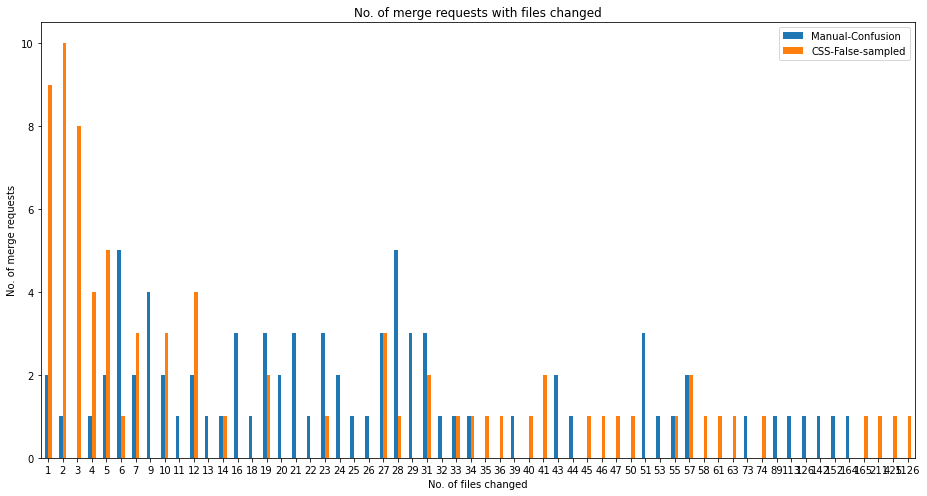

In [226]:
plt.rcParams["figure.figsize"] = [13, 7]
plt.rcParams["figure.autolayout"] = True

confusion_changesCount = pd.to_numeric(confusion_smell_df['changesCount']).value_counts().sort_index()
sample_changesCount = pd.to_numeric(sample_mrDF['changesCount']).value_counts().sort_index()
df = pd.DataFrame({'Manual-Confusion': confusion_changesCount, 'CSS-False-sampled':sample_changesCount})
df.plot.bar(rot=0)
plt.title('No. of merge requests with files changed')
plt.xlabel("No. of files changed")
plt.ylabel("No. of merge requests")
plt.show()

In [166]:
# SAMPLING
#taking 79 samples, one sample per merge request so that we have 79 mergeRequest which doesn't include any keyword from framework
#also controlling the changesCount variable by taking same amount of sample from each mr type category
# sample1_feature = mrDF[(mrDF['changesCount']>0) & (mrDF['changesCount']<=30) & (mrDF['CCS']==False) & (mrDF['type']=='feature')].sample(n=45)
# sample1_bugfix = mrDF[(mrDF['changesCount']>0) & (mrDF['changesCount']<=30) & (mrDF['CCS']==False) & (mrDF['type']=='bugfix')].sample(n=7)
# sample1_test = mrDF[(mrDF['changesCount']>0) & (mrDF['changesCount']<=30) & (mrDF['CCS']==False) & (mrDF['type']=='test')].sample(n=1)
# sample1_fix = mrDF[(mrDF['changesCount']>0) & (mrDF['changesCount']<=30) & (mrDF['CCS']==False) & (mrDF['type']=='fix')].sample(n=1)
# sample1_QA = mrDF[(mrDF['changesCount']>0) & (mrDF['changesCount']<=30) & (mrDF['CCS']==False) & (mrDF['type']=='QA')].sample(n=1)
# sample1 = sample1_feature.append(sample1_bugfix, ignore_index=True).append(sample1_test, ignore_index=True).append(sample1_fix, ignore_index=True).append(sample1_QA, ignore_index=True)
# sample2 = mrDF[(mrDF['changesCount']>30) & (mrDF['changesCount']<=60) & (mrDF['CCS']==False)].sample(n=17)
# sample3 = mrDF[(mrDF['changesCount']>60) & (mrDF['CCS']==False)].sample(n=7)
# sample_mrDF= sample1.append(sample2, ignore_index=True).append(sample3, ignore_index=True)
# len(sample_mrDF)

# sampleMRIID = [1617, 1627, 1629, 1635, 1637, 1642, 1646, 1647, 1652, 1655, 1660, 1667,
#        1674, 1681, 1687, 1697, 1702, 1705, 1711, 1712, 1717, 1719, 1721,
#        1728, 1732, 1733, 1736, 1746, 1775, 1776, 1782, 1789, 1791, 1815,
#        1823, 1824, 1826, 1830, 1859, 1875, 1878, 1879, 1881, 1883, 1884,
#        1886, 1893, 1904, 1905, 1909, 1916, 1918, 1919, 1920, 1921, 1930,
#        1933, 1939, 1940, 1941, 1950, 1964, 1966, 1967, 1970, 1975, 1983,
#        1988, 2004, 2006, 2014, 2015, 2017, 2018, 2022, 2026, 2031,
#        2036, 2039]

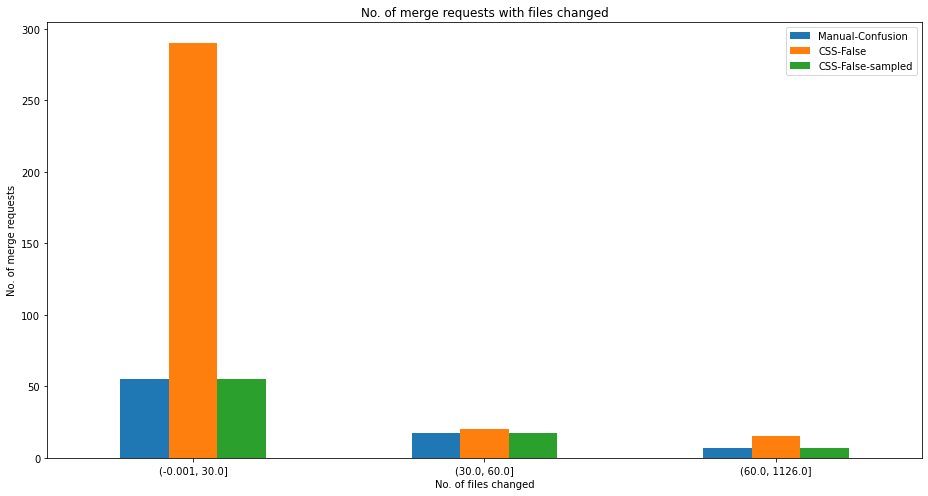

,Manual-Confusion,CSS-False,CSS-False-sampled
"(-0.001, 30.0]",55,290,55
"(30.0, 60.0]",17,20,17
"(60.0, 1126.0]",7,15,7


<Figure size 936x504 with 0 Axes>

In [277]:
#checking the distribution of changesCount from manual true confusion and CSS false 
data= pd.to_numeric(confusion_smell_df['changesCount'])
bins = [0,30,60,max(mrDF['changesCount'])]
out = pd.cut(data, bins, include_lowest=True)
data2 = pd.to_numeric(mrDF[(mrDF['CCS']==False)]['changesCount'])
out2 = pd.cut(data2, bins, include_lowest=True)
sampled_data = pd.to_numeric(sample_mrDF['changesCount'])
out3 = pd.cut(sampled_data, bins, include_lowest=True)

df = pd.DataFrame({'Manual-Confusion': out.value_counts(sort=False), 'CSS-False':out2.value_counts(sort=False), 'CSS-False-sampled':out3.value_counts(sort=False)})
df.plot.bar(rot=0)
plt.title('No. of merge requests with files changed')
plt.xlabel("No. of files changed")
plt.ylabel("No. of merge requests")
plt.show()
plt.savefig('books_read.png')
df

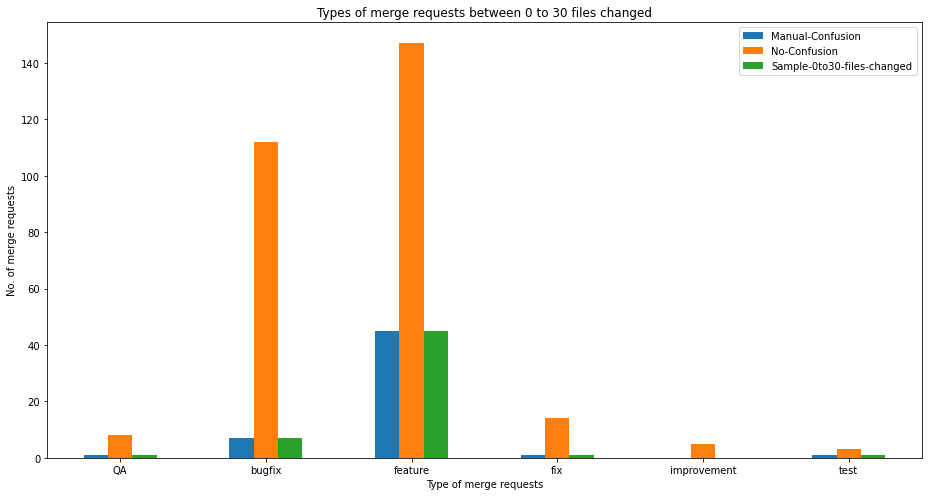

,Manual-Confusion,No-Confusion,Sample-0to30-files-changed
QA,1.0,8,1.0
bugfix,7.0,112,7.0
feature,45.0,147,45.0
fix,1.0,14,1.0
improvement,NaN,5,NaN
test,1.0,3,1.0


In [13]:
type_confusion_true_0_30 = confusion_smell_df[(confusion_smell_df['changesCount']>0) & (confusion_smell_df['changesCount']<=30)]['type'].value_counts(sort=False)
type_css_false_0_30 = mrDF[(mrDF['changesCount']>0) & (mrDF['changesCount']<=30) & (mrDF['CCS']==False)]['type'].value_counts(sort=False)
type_sample1_0_30 = sample_mrDF[(sample_mrDF['changesCount']>0) & (sample_mrDF['changesCount']<=30)]['type'].value_counts(sort=False)
type_0_30_df = pd.DataFrame({'Manual-Confusion': type_confusion_true_0_30,'No-Confusion':type_css_false_0_30 ,'Sample-0to30-files-changed':type_sample1_0_30})


type_0_30_df.plot.bar(rot=0)
plt.title('Types of merge requests between 0 to 30 files changed')
plt.xlabel("Type of merge requests")
plt.ylabel("No. of merge requests")
plt.show()
type_0_30_df

C:\Users\MAYUR~1.WAG\AppData\Local\Temp/ipykernel_15532/2298238131.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  type_sample2_30_60 = sample_mrDF[(mrDF['changesCount']>30) & (sample_mrDF['changesCount']<=60)]['type'].value_counts(sort=False)


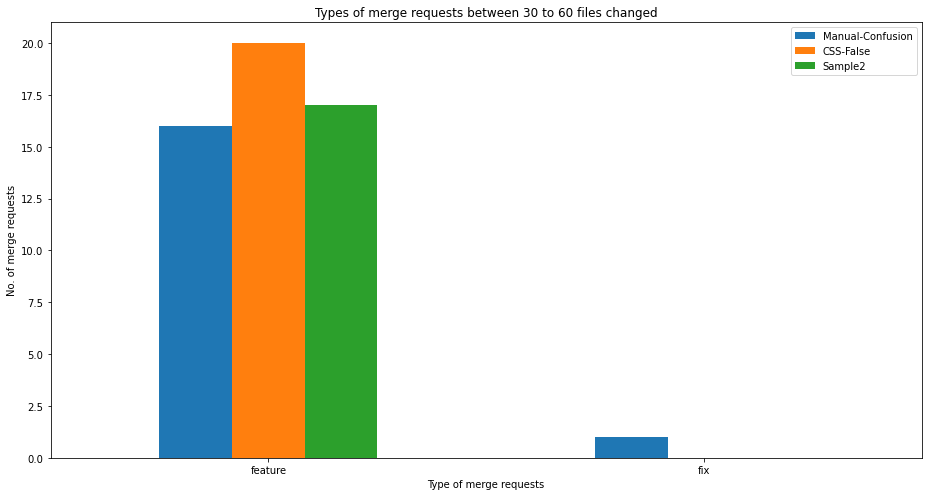

,Manual-Confusion,CSS-False,Sample2
feature,16,20.0,17.0
fix,1,NaN,NaN


In [231]:
type_confusion_true_30_60 = confusion_smell_df[(confusion_smell_df['changesCount']>30) & (confusion_smell_df['changesCount']<=60)]['type'].value_counts(sort=False)
type_css_false_30_60 = mrDF[(mrDF['changesCount']>30) & (mrDF['changesCount']<=60) & (mrDF['CCS']==False)]['type'].value_counts(sort=False)
type_sample2_30_60 = sample_mrDF[(mrDF['changesCount']>30) & (sample_mrDF['changesCount']<=60)]['type'].value_counts(sort=False)
type_30_60_df = pd.DataFrame({'Manual-Confusion': type_confusion_true_30_60,'CSS-False':type_css_false_30_60 ,'Sample2':type_sample2_30_60})

type_30_60_df.plot.bar(rot=0)
plt.title('Types of merge requests between 30 to 60 files changed')
plt.xlabel("Type of merge requests")
plt.ylabel("No. of merge requests")
plt.show()
type_30_60_df

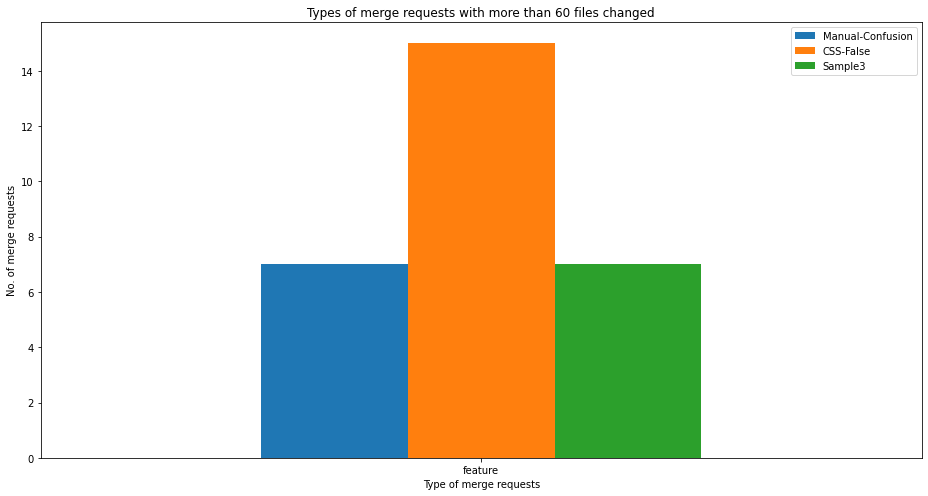

,Manual-Confusion,CSS-False,Sample3
feature,7,15,7


In [232]:
type_confusion_true_60 = confusion_smell_df[(confusion_smell_df['changesCount']>60)]['type'].value_counts(sort=False)
type_css_false_60 = mrDF[(mrDF['changesCount']>60) & (mrDF['CCS']==False)]['type'].value_counts(sort=False)
type_sample3_60 = sample_mrDF[(sample_mrDF['changesCount']>60)]['type'].value_counts(sort=False)
type_60_df = pd.DataFrame({'Manual-Confusion': type_confusion_true_60,'CSS-False':type_css_false_60 ,'Sample3':type_sample3_60})

type_60_df.plot.bar(rot=0)
plt.title('Types of merge requests with more than 60 files changed')
plt.xlabel("Type of merge requests")
plt.ylabel("No. of merge requests")
plt.show()
type_60_df

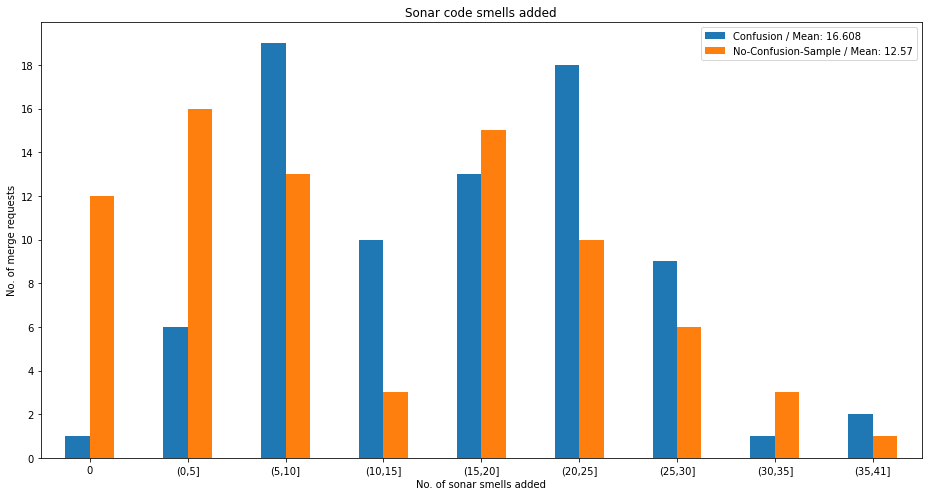

In [11]:
#checking the distribution of sonar_added from MR data
confusion_data = pd.to_numeric(confusion_smell_df['sonar_added'])
sample_data = pd.to_numeric(sample_mrDF['sonar_added'])
bins=[0,0.1,5,10,15,20,25,30,35,max(max(confusion_data), max(sample_data))]
out = pd.cut(confusion_data, bins, include_lowest=True)
out2 = pd.cut(sample_data, bins, include_lowest=True)
fig, ax = plt.subplots()
df = pd.DataFrame({'Manual-Confusion': out.value_counts(sort=False), 'CSS-False-sampled':out2.value_counts(sort=False)})
df.plot.bar(ax=ax, rot=0)
plt.title('Sonar code smells added')
plt.xlabel("No. of sonar smells added")
plt.ylabel("No. of merge requests")
confusion_mean = np.round(np.mean(confusion_data), 3)
sample_mean = np.round(np.mean(sample_data), 3)
ax.legend(['Confusion / Mean: '+str(confusion_mean), 'No-Confusion-Sample / Mean: '+str(sample_mean)])
ax.set_xticklabels(['0','(0,5]','(5,10]', '(10,15]','(15,20]', '(20,25]', '(25,30]','(30,35]','(35,41]'])
plt.yticks(np.arange(0, max(max(df['Manual-Confusion']),max(df['CSS-False-sampled']))+1, 2.0))

plt.show()

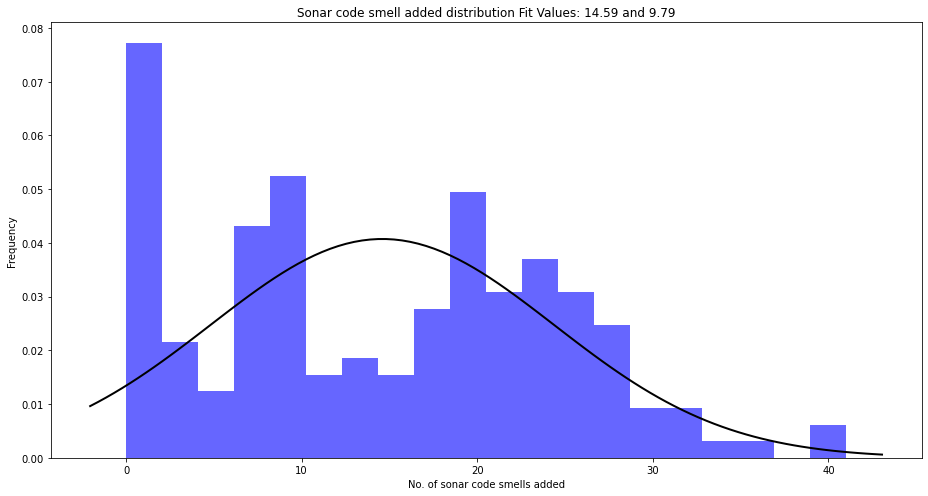

In [286]:
#trying histogramog all sonar added with bell curve
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
mu, std = norm.fit(mrDF[~mrDF['sonar_added'].isna()]['sonar_added']) 
plt.hist(mrDF[~mrDF['sonar_added'].isna()]['sonar_added'], bins=20, density=True, alpha=0.6, color='b')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
  
plt.plot(x, p, 'k', linewidth=2)
title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
plt.title('Sonar code smell added distribution ' + title)
plt.xlabel('No. of sonar code smells added')
plt.ylabel('Frequency')
plt.show()


# confusion_smell_df[['sonar_added']].plot.hist(bins=20)

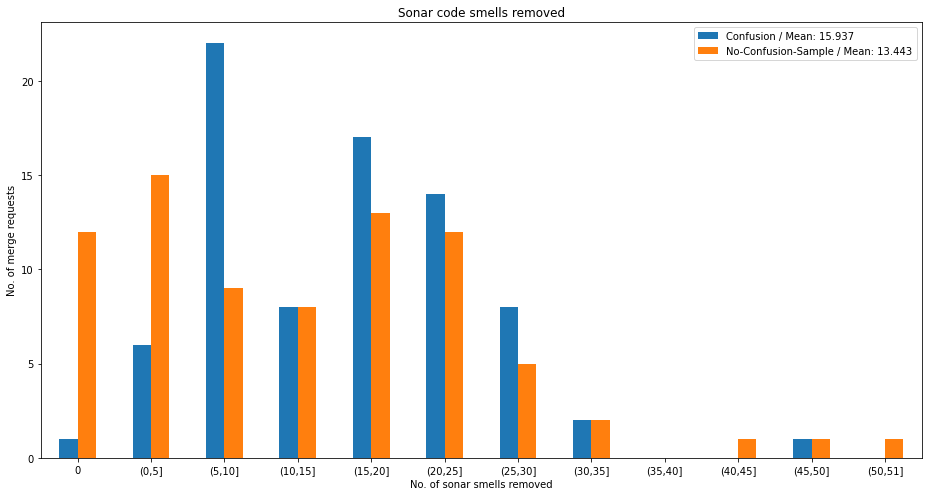

In [17]:
#checking the distribution of sonar_removed from MR data
confusion_data = pd.to_numeric(confusion_smell_df['sonar_removed'])
sample_data = pd.to_numeric(sample_mrDF['sonar_removed'])
bins=[0,0.1,5,10,15,20,25,30,35,40,45,50,max(max(confusion_data), max(sample_data))]
out = pd.cut(confusion_data, bins, include_lowest=True)
out2 = pd.cut(sample_data, bins, include_lowest=True)
fig, ax = plt.subplots()
df = pd.DataFrame({'Manual-Confusion': out.value_counts(sort=False), 'CSS-False-sampled':out2.value_counts(sort=False)})
df.plot.bar(ax=ax, rot=0)
plt.title('Sonar code smells removed')
plt.xlabel("No. of sonar smells removed")
plt.ylabel("No. of merge requests")
confusion_mean = np.round(np.mean(confusion_data), 3)
sample_mean = np.round(np.mean(sample_data), 3)
ax.legend(['Confusion / Mean: '+str(confusion_mean), 'No-Confusion-Sample / Mean: '+str(sample_mean)])
ax.set_xticklabels(['0','(0,5]','(5,10]', '(10,15]','(15,20]', '(20,25]', '(25,30]','(30,35]','(35,40]','(40,45]','(45,50]','(50,51]'])
plt.show()
# print(out.value_counts(sort=False), out2.value_counts(sort=False))

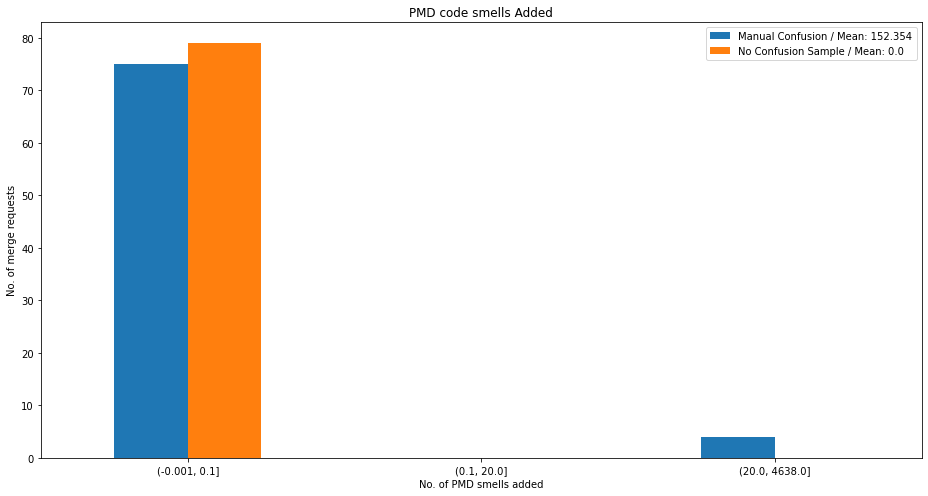

152.35443037974684 0.0


In [293]:
#checking the distribution of pmd_added from MR data
confusion_data = pd.to_numeric(confusion_smell_df['pmd_added'])
sample_data = pd.to_numeric(sample_mrDF['pmd_added'])
bins=[0,0.1,20,max(max(confusion_data), max(sample_data))]
out = pd.cut(confusion_data, bins, include_lowest=True)
out2 = pd.cut(sample_data, bins, include_lowest=True)
fig, ax = plt.subplots()
df = pd.DataFrame({'Manual-Confusion': out.value_counts(sort=False), 'CSS-False-sampled':out2.value_counts(sort=False)})
df.plot.bar(ax=ax, rot=0)
plt.title('PMD code smells Added')
plt.xlabel("No. of PMD smells added")
plt.ylabel("No. of merge requests")
confusion_mean = np.round(np.mean(confusion_data), 3)
sample_mean = np.round(np.mean(sample_data), 3)
ax.legend(['Manual Confusion / Mean: '+str(confusion_mean), 'No Confusion Sample / Mean: '+str(sample_mean)])
plt.show()
# print(out.value_counts(sort=False), out2.value_counts(sort=False))
print(np.mean(confusion_data), np.mean(sample_data))

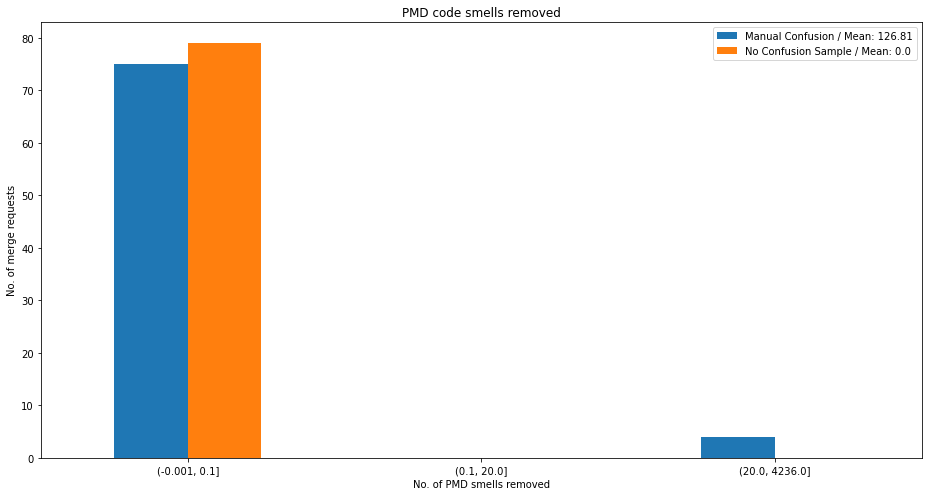

126.81012658227849 0.0


In [295]:
#checking the distribution of pmd_removed from MR data
confusion_data = pd.to_numeric(confusion_smell_df['pmd_removed'])
sample_data = pd.to_numeric(sample_mrDF['pmd_removed'])
bins=[0,0.1,20,max(max(confusion_data), max(sample_data))]
out = pd.cut(confusion_data, bins, include_lowest=True)
out2 = pd.cut(sample_data, bins, include_lowest=True)
fig, ax = plt.subplots()
df = pd.DataFrame({'Manual-Confusion': out.value_counts(sort=False), 'CSS-False-sampled':out2.value_counts(sort=False)})
df.plot.bar(ax=ax, rot=0)
plt.title('PMD code smells removed')
plt.xlabel("No. of PMD smells removed")
plt.ylabel("No. of merge requests")
confusion_mean = np.round(np.mean(confusion_data), 3)
sample_mean = np.round(np.mean(sample_data), 3)
ax.legend(['Manual Confusion / Mean: '+str(confusion_mean), 'No Confusion Sample / Mean: '+str(sample_mean)])
plt.show()
# print(out.value_counts(sort=False), out2.value_counts(sort=False))
print(np.mean(confusion_data), np.mean(sample_data))

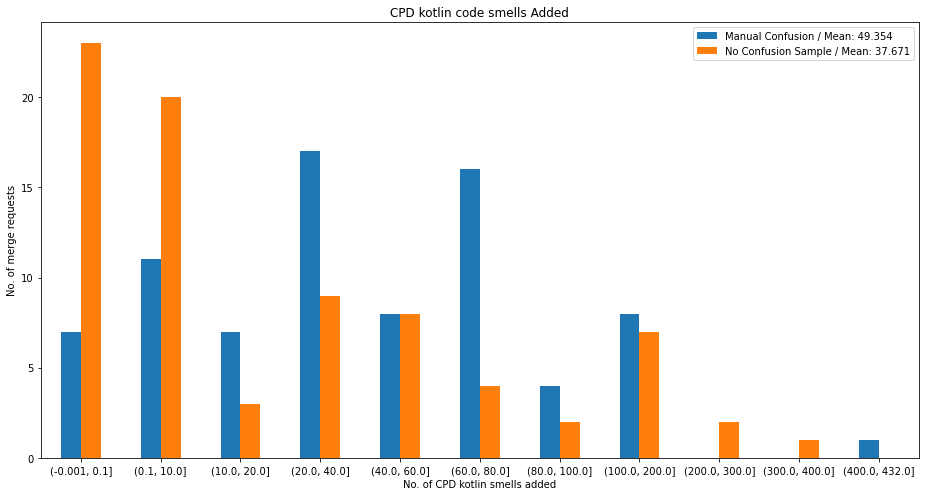

49.35443037974684 37.67088607594937


In [296]:
#checking the distribution of cpd_kotlin_added from MR data
confusion_data = pd.to_numeric(confusion_smell_df['cpd_kotlin_added'])
sample_data = pd.to_numeric(sample_mrDF['cpd_kotlin_added'])
bins=[0,0.1,10,20,40,60,80,100,200,300,400,max(max(confusion_data), max(sample_data))]
out = pd.cut(confusion_data, bins, include_lowest=True)
out2 = pd.cut(sample_data, bins, include_lowest=True)
fig, ax = plt.subplots()
df = pd.DataFrame({'Manual-Confusion': out.value_counts(sort=False), 'CSS-False-sampled':out2.value_counts(sort=False)})
df.plot.bar(ax=ax, rot=0)
plt.title('CPD kotlin code smells Added')
plt.xlabel("No. of CPD kotlin smells added")
plt.ylabel("No. of merge requests")
confusion_mean = np.round(np.mean(confusion_data), 3)
sample_mean = np.round(np.mean(sample_data), 3)
ax.legend(['Manual Confusion / Mean: '+str(confusion_mean), 'No Confusion Sample / Mean: '+str(sample_mean)])
plt.show()
# print(out.value_counts(sort=False), out2.value_counts(sort=False))
print(np.mean(confusion_data), np.mean(sample_data))

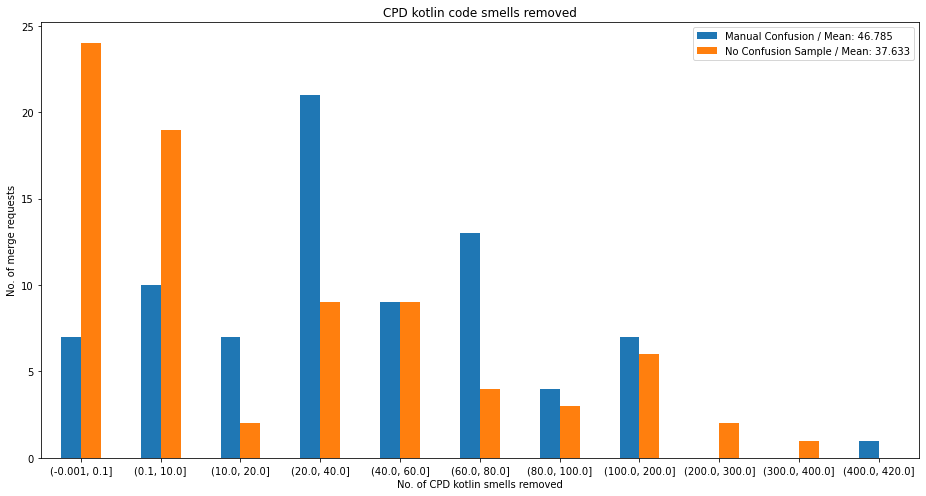

46.78481012658228 37.63291139240506


In [297]:
#checking the distribution of cpd_kotlin_removed from MR data
confusion_data = pd.to_numeric(confusion_smell_df['cpd_kotlin_removed'])
sample_data = pd.to_numeric(sample_mrDF['cpd_kotlin_removed'])
bins=[0,0.1,10,20,40,60,80,100,200,300,400,max(max(confusion_data), max(sample_data))]
out = pd.cut(confusion_data, bins, include_lowest=True)
out2 = pd.cut(sample_data, bins, include_lowest=True)
fig, ax = plt.subplots()
df = pd.DataFrame({'Manual-Confusion': out.value_counts(sort=False), 'CSS-False-sampled':out2.value_counts(sort=False)})
df.plot.bar(ax=ax, rot=0)
plt.title('CPD kotlin code smells removed')
plt.xlabel("No. of CPD kotlin smells removed")
plt.ylabel("No. of merge requests")
confusion_mean = np.round(np.mean(confusion_data), 3)
sample_mean = np.round(np.mean(sample_data), 3)
ax.legend(['Manual Confusion / Mean: '+str(confusion_mean), 'No Confusion Sample / Mean: '+str(sample_mean)])
plt.show()
# print(out.value_counts(sort=False), out2.value_counts(sort=False))
print(np.mean(confusion_data), np.mean(sample_data))

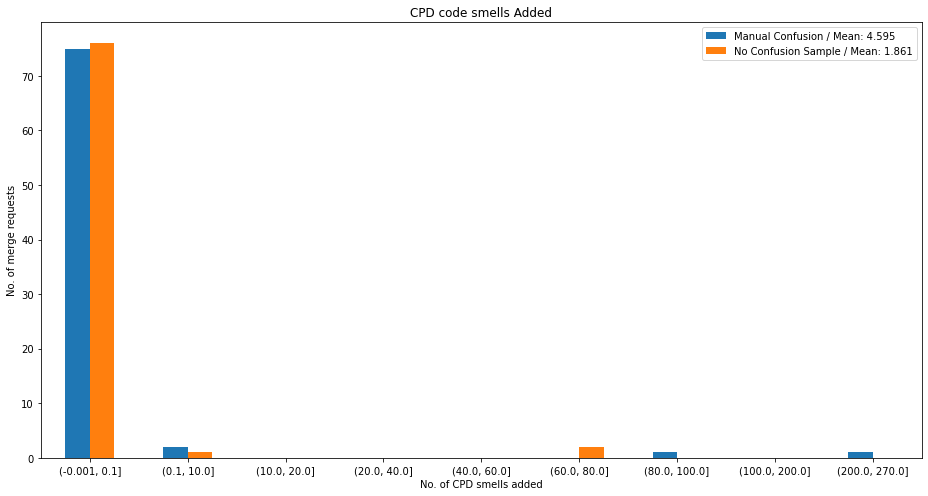

4.594936708860759 1.860759493670886


In [298]:
#checking the distribution of cpd_added from MR data
confusion_data = pd.to_numeric(confusion_smell_df['cpd_added'])
sample_data = pd.to_numeric(sample_mrDF['cpd_added'])
bins=[0,0.1,10,20,40,60,80,100,200,max(max(confusion_data), max(sample_data))]
out = pd.cut(confusion_data, bins, include_lowest=True)
out2 = pd.cut(sample_data, bins, include_lowest=True)
fig, ax = plt.subplots()
df = pd.DataFrame({'Manual-Confusion': out.value_counts(sort=False), 'CSS-False-sampled':out2.value_counts(sort=False)})
df.plot.bar(ax=ax, rot=0)
plt.title('CPD code smells Added')
plt.xlabel("No. of CPD smells added")
plt.ylabel("No. of merge requests")
confusion_mean = np.round(np.mean(confusion_data), 3)
sample_mean = np.round(np.mean(sample_data), 3)
ax.legend(['Manual Confusion / Mean: '+str(confusion_mean), 'No Confusion Sample / Mean: '+str(sample_mean)])
plt.show()
plt.show()
# print(out.value_counts(sort=False), out2.value_counts(sort=False))
print(np.mean(confusion_data), np.mean(sample_data))

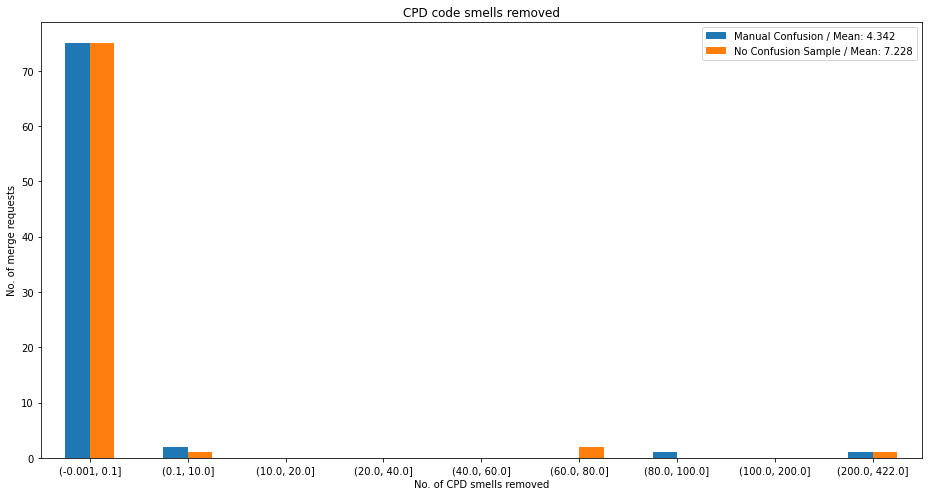

4.341772151898734 7.227848101265823


In [299]:
#checking the distribution of cpd_removed from MR data
confusion_data = pd.to_numeric(confusion_smell_df['cpd_removed'])
sample_data = pd.to_numeric(sample_mrDF['cpd_removed'])
bins=[0,0.1,10,20,40,60,80,100,200,max(max(confusion_data), max(sample_data))]
out = pd.cut(confusion_data, bins, include_lowest=True)
out2 = pd.cut(sample_data, bins, include_lowest=True)
fig, ax = plt.subplots()
df = pd.DataFrame({'Manual-Confusion': out.value_counts(sort=False), 'CSS-False-sampled':out2.value_counts(sort=False)})
df.plot.bar(ax=ax, rot=0)
plt.title('CPD code smells removed')
plt.xlabel("No. of CPD smells removed")
plt.ylabel("No. of merge requests")
confusion_mean = np.round(np.mean(confusion_data), 3)
sample_mean = np.round(np.mean(sample_data), 3)
ax.legend(['Manual Confusion / Mean: '+str(confusion_mean), 'No Confusion Sample / Mean: '+str(sample_mean)])
plt.show()
plt.show()
# print(out.value_counts(sort=False), out2.value_counts(sort=False))
print(np.mean(confusion_data), np.mean(sample_data))

In [3]:
mrDF.to_excel('final_data/Final_all_mr_smells_data.xlsx')
sample_mrDF.to_excel('final_data/Final_sample_mr_smells_data.xlsx')
manual_label.to_excel('final_data/Final_manual_mr_data.xlsx')
confusion_smell_df.to_excel('final_data/Final_manual_mr_smells_data.xlsx')

NameError: name 'mrDF' is not defined

In [14]:
import pandas as pd
confusion_smell_df = pd.read_excel('final_data/Final_manual_labels_mr_data.xlsx')
# confusion_smell_df = confusion_smell_df.fillna(0)

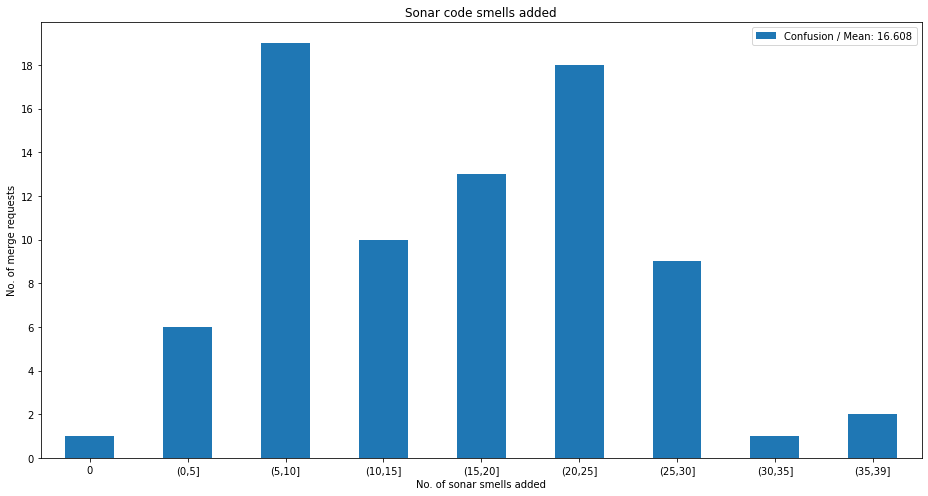

In [15]:
plt.rcParams["figure.figsize"] = [13, 7]
plt.rcParams["figure.autolayout"] = True
#checking the distribution of sonar_removed from MR data
confusion_data = pd.to_numeric(confusion_smell_df['sonar_added'])
bins=[0,0.1,5,10,15,20,25,30,35,max(confusion_data)]
out = pd.cut(confusion_data, bins, include_lowest=True)
fig, ax = plt.subplots()
df = pd.DataFrame({'Manual-Confusion': out.value_counts(sort=False)})
df.plot.bar(ax=ax, rot=0)
plt.title('Sonar code smells added')
plt.xlabel("No. of sonar smells added")
plt.ylabel("No. of merge requests")
confusion_mean = np.round(np.mean(confusion_data), 3)
ax.legend(['Confusion / Mean: '+str(confusion_mean)])
ax.set_xticklabels(['0','(0,5]','(5,10]', '(10,15]','(15,20]', '(20,25]', '(25,30]','(30,35]','(35,39]'])
plt.yticks(np.arange(0, max(df['Manual-Confusion'])+1, 2.0))
plt.show()
# print(out.value_counts(sort=False), out2.value_counts(sort=False))

In [16]:
mrDF = pd.read_excel('final_data/all_merge_requests_with_manual_labelling_and_code_smells_data.xlsx')
sample_mrDF = pd.read_excel('final_data/Merge_request_sample_no_confusion_smells_data.xlsx')

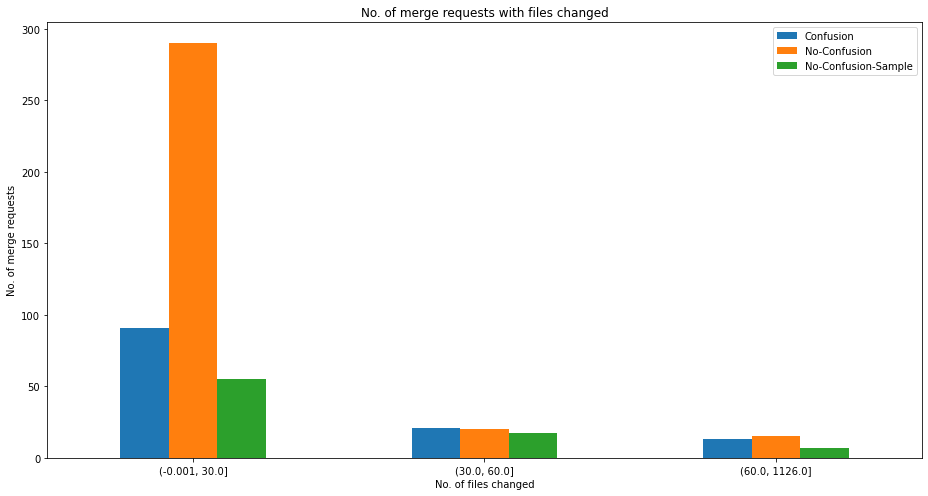

,Confusion,No-Confusion,No-Confusion-Sample
"(-0.001, 30.0]",91,290,55
"(30.0, 60.0]",21,20,17
"(60.0, 1126.0]",13,15,7


<Figure size 936x504 with 0 Axes>

In [12]:
#checking the distribution of changesCount from manual true confusion and CSS false 
data= pd.to_numeric(confusion_smell_df['changesCount'])
bins = [0,30,60,max(mrDF['changesCount'])]
out = pd.cut(data, bins, include_lowest=True)
data2 = pd.to_numeric(mrDF[(mrDF['CCS']==False)]['changesCount'])
out2 = pd.cut(data2, bins, include_lowest=True)
sampled_data = pd.to_numeric(sample_mrDF['changesCount'])
out3 = pd.cut(sampled_data, bins, include_lowest=True)

df = pd.DataFrame({'Confusion': out.value_counts(sort=False), 'No-Confusion':out2.value_counts(sort=False), 'No-Confusion-Sample':out3.value_counts(sort=False)})
df.plot.bar(rot=0)
plt.title('No. of merge requests with files changed')
plt.xlabel("No. of files changed")
plt.ylabel("No. of merge requests")
plt.show()
plt.savefig('books_read.png')
df

In [334]:
sonar_list = os.listdir('./SonarReport/')
added_smell_details_DF = pd.DataFrame(columns=['MRIID','Rule key'])
for MRIID in confusion_MRIID:
    sonar_after_file = [k for k in sonar_list if str(MRIID) in k.split('-') and 'after' in k]
    sonar_before_file = [k for k in sonar_list if str(MRIID) in k.split('-') and 'before' in k]
    if(len(sonar_after_file)==1 and len(sonar_before_file)==1):
        before = pd.read_excel('./SonarReport/'+sonar_before_file[0])
        after = pd.read_excel('./SonarReport/'+sonar_after_file[0])
        before['Count'] = 1
        before = before.groupby(['Resource','Date','Description','Path','Rule key','Server issue key'],dropna=False).Count.count().reset_index().drop_duplicates()
        after['Count'] = 1
        after = after.groupby(['Resource','Date','Description','Path','Rule key','Server issue key'],dropna=False).Count.count().reset_index().drop_duplicates()
        df = pd.merge(before, after, on=['Resource','Description','Path','Rule key','Server issue key'], how="outer", indicator=True)
        df['Count_x'] = df['Count_x'].fillna(0)
        df['Count_y'] = df['Count_y'].fillna(0)
        smells_removed = sum(df[df['Count_x']>df['Count_y']]['Count_x'] - df[df['Count_x']>df['Count_y']]['Count_y'])
        
        smells_added = sum(df[df['Count_x']<df['Count_y']]['Count_y'] - df[df['Count_x']<df['Count_y']]['Count_x'])
        for I,row in df[df['Count_x']<df['Count_y']].iterrows():
            for i in range(int(row['Count_y']-row['Count_x'])):
                added_smell_details_DF.loc[len(added_smell_details_DF)] = [MRIID, row['Rule key']]
        
        smells_existed = sum(df[df['Count_x']==df['Count_y']]['Count_x']) + sum(df[df['Count_x']<df['Count_y']]['Count_x']) + sum(df[df['Count_x']>df['Count_y']]['Count_y'])

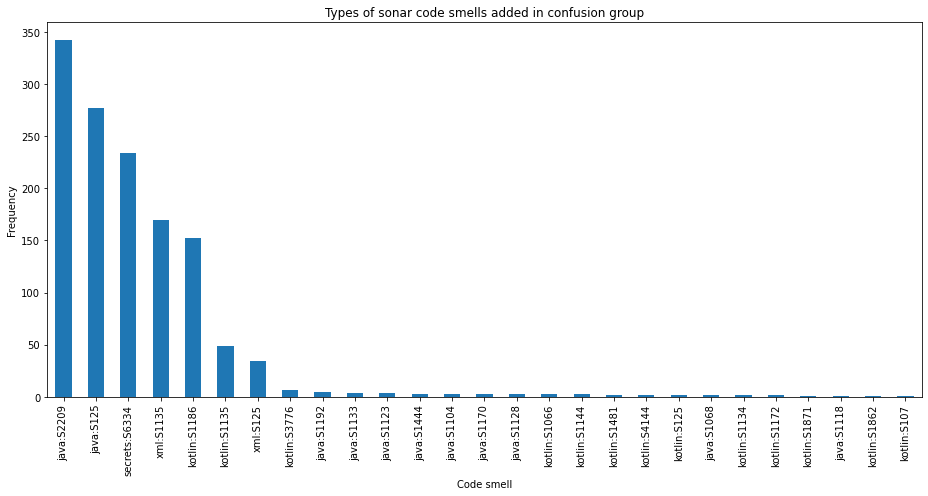

In [343]:
fig, ax = plt.subplots()
added_smell_details_DF["Rule key"].value_counts().plot(ax=ax, kind='bar')
plt.xlabel('Code smell')
plt.ylabel('Frequency')
plt.title('Types of sonar code smells added in confusion group')
plt.show()

In [336]:
added_smell_sample_details_DF = pd.DataFrame(columns=['MRIID','Rule key'])
sonar_list = os.listdir('./SonarReport_sample/')
for MRIID in sample_MRIID:
    sonar_after_file = [k for k in sonar_list if str(MRIID) in k.split('-') and 'after' in k]
    sonar_before_file = [k for k in sonar_list if str(MRIID) in k.split('-') and 'before' in k]
    if(len(sonar_after_file)==1 and len(sonar_before_file)==1):
        before = pd.read_excel('./SonarReport_sample/'+sonar_before_file[0])
        after = pd.read_excel('./SonarReport_sample/'+sonar_after_file[0])
        before['Count'] = 1
        before = before.groupby(['Resource','Date','Description','Path','Rule key','Server issue key'],dropna=False).Count.count().reset_index().drop_duplicates()
        after['Count'] = 1
        after = after.groupby(['Resource','Date','Description','Path','Rule key','Server issue key'],dropna=False).Count.count().reset_index().drop_duplicates()
        df = pd.merge(before, after, on=['Resource','Description','Path','Rule key','Server issue key'], how="outer", indicator=True)
        df['Count_x'] = df['Count_x'].fillna(0)
        df['Count_y'] = df['Count_y'].fillna(0)
        smells_removed = sum(df[df['Count_x']>df['Count_y']]['Count_x'] - df[df['Count_x']>df['Count_y']]['Count_y'])
        smells_added = sum(df[df['Count_x']<df['Count_y']]['Count_y'] - df[df['Count_x']<df['Count_y']]['Count_x'])
        
        for I,row in df[df['Count_x']<df['Count_y']].iterrows():
            for i in range(int(row['Count_y']-row['Count_x'])):
                added_smell_sample_details_DF.loc[len(added_smell_sample_details_DF)] = [MRIID, row['Rule key']]
        
        smells_existed = sum(df[df['Count_x']==df['Count_y']]['Count_x']) + sum(df[df['Count_x']<df['Count_y']]['Count_x']) + sum(df[df['Count_x']>df['Count_y']]['Count_y'])

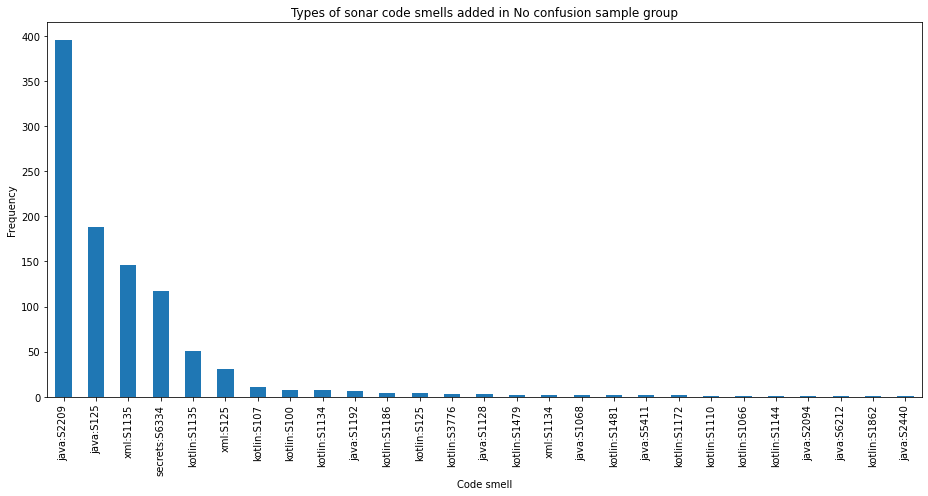

In [344]:
fig, ax = plt.subplots()
added_smell_sample_details_DF["Rule key"].value_counts().plot(ax=ax, kind='bar')
plt.xlabel('Code smell')
plt.ylabel('Frequency')
plt.title('Types of sonar code smells added in No confusion sample group')
plt.show()

In [351]:
confusion_added_smell_details = added_smell_details_DF["Rule key"].value_counts().rename_axis('Rule key').reset_index(name='counts')
No_confusion_added_smell_details = added_smell_sample_details_DF["Rule key"].value_counts().rename_axis('Rule key').reset_index(name='counts')

In [360]:
all_smell_details = pd.merge(confusion_added_smell_details, No_confusion_added_smell_details, on=['Rule key'], how="outer", indicator=True)
# all_smell_details = all_smell_details.fillna(0)
all_smell_details['counts_x'] = all_smell_details['counts_x'].fillna(0)
all_smell_details['counts_y'] = all_smell_details['counts_y'].fillna(0)
all_smell_details

,Rule key,counts_x,counts_y,_merge
0,java:S2209,342.0,395.0,both
1,java:S125,277.0,188.0,both
2,secrets:S6334,234.0,117.0,both
3,xml:S1135,170.0,146.0,both
4,kotlin:S1186,152.0,4.0,both
5,kotlin:S1135,49.0,51.0,both
6,xml:S125,34.0,31.0,both
7,kotlin:S3776,7.0,3.0,both
8,java:S1192,5.0,6.0,both
9,java:S1133,4.0,0.0,left_only


In [361]:
all_smell_details[all_smell_details['counts_x']>all_smell_details['counts_y']]

,Rule key,counts_x,counts_y,_merge
1,java:S125,277.0,188.0,both
2,secrets:S6334,234.0,117.0,both
3,xml:S1135,170.0,146.0,both
4,kotlin:S1186,152.0,4.0,both
6,xml:S125,34.0,31.0,both
7,kotlin:S3776,7.0,3.0,both
9,java:S1133,4.0,0.0,left_only
10,java:S1123,4.0,0.0,left_only
11,java:S1444,3.0,0.0,left_only
12,java:S1104,3.0,0.0,left_only


C:\Users\mayur.waghela\Anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


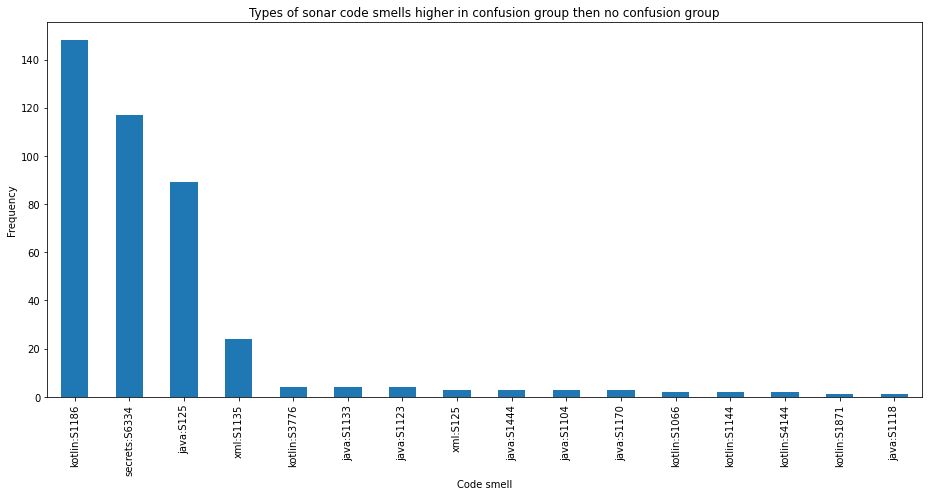

In [376]:
only_confusion_smell_numbers = all_smell_details[all_smell_details['counts_x']>all_smell_details['counts_y']]
only_confusion_smell_numbers.loc[:,'only_confusion'] = only_confusion_smell_numbers['counts_x'] - only_confusion_smell_numbers['counts_y']

only_confusion_smell_numbers.sort_values('only_confusion', ascending=False).plot.bar(x='Rule key', y='only_confusion', rot=0, legend=False)
plt.xlabel('Code smell')
plt.ylabel('Frequency')
plt.title('Types of sonar code smells higher in confusion group then no confusion group')

plt.xticks(rotation=90)
plt.show()

In [373]:
added_smell_sample_details_DF["Rule key"].value_counts()

java:S2209       395
java:S125        188
xml:S1135        146
secrets:S6334    117
kotlin:S1135      51
xml:S125          31
kotlin:S107       11
kotlin:S100        8
kotlin:S1134       7
java:S1192         6
kotlin:S1186       4
kotlin:S125        4
kotlin:S3776       3
java:S1128         3
kotlin:S1479       2
xml:S1134          2
java:S1068         2
kotlin:S1481       2
java:S5411         2
kotlin:S1172       2
kotlin:S1110       1
kotlin:S1066       1
kotlin:S1144       1
java:S2094         1
java:S6212         1
kotlin:S1862       1
java:S2440         1
Name: Rule key, dtype: int64

In [13]:
sample_mrDF

,Unnamed: 0,MRIID,projectID,title,description,state,createdAt,mergedAt,targetBranch,sourceBranch,...,cpd_kotlin_existed,cpd_removed,cpd_added,cpd_existed,pmd_removed,pmd_added,pmd_existed,sonar_removed,sonar_added,sonar_existed
0,2,1617,3982,CDTE-26343,Added Segur implemetation (Document Listing & ...,merged,2022-04-01 11:32:32,2022-04-01 11:35:02,feature/segur,feature/CDTE-26343_documents_section,...,1725,0,0,368,0,0,2348,3,3,583
1,12,1627,3982,Updated covid 19 search text,NaN,merged,2022-04-04 14:20:17,2022-04-04 14:35:06,release/22.2.0,bugfix/2022/S13/Updated_covid_19_search_text,...,1764,0,0,305,0,0,2348,5,5,652
2,14,1629,3982,CDTE-27557,Switched prescription listing: view_orders wi...,merged,2022-04-05 13:21:24,2022-04-05 13:38:36,feature/eprescription-rewrite,feature/CDTE-27557_scan_data_matrix_prescripti...,...,1811,70,70,289,0,0,2348,23,8,638
3,18,1635,3982,CDTE-27969,Added most common TextAppearances referenced i...,merged,2022-04-06 10:54:34,2022-04-06 11:31:41,develop,feature/CDTE-27969_refactor_styles_typefaces,...,1811,0,0,359,0,0,2348,6,7,657
4,20,1637,3982,CDTE-10407 CI CD tests,NaN,merged,2022-04-08 07:45:59,2022-06-14 11:03:19,develop,feature/2022/S14/CDTE-10407_ci_cd_gitlab,...,1999,0,0,388,0,0,2348,11,11,751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,390,2022,3982,"Resolve CDTE-28034 ""Test/ sprint23""",Related to CDTE-28034,merged,2022-09-13 06:57:50,2022-09-14 10:13:38,develop,test/CDTE-28034-Sprint23,...,2037,0,0,0,0,0,2680,13,10,606
75,394,2026,3982,CDTE-33980 Update appointment details text,Related to CDTE-33980,merged,2022-09-13 13:45:14,2022-09-14 10:52:04,develop,bugfix/2022/S25/CDTE-33980_Appointment_details...,...,2037,0,0,0,0,0,2680,1,1,617
76,399,2031,3982,CDTE-33777,Added Erezept medication details screen & logi...,merged,2022-09-14 10:53:23,2022-09-14 10:55:37,feature/eprescription-rewrite,feature/CDTE-33777_erezept_medication_details_...,...,2036,0,0,0,0,0,2680,0,0,630
77,404,2036,3982,Merge 22.6 into develop,CDTE-32658 Changed strings,merged,2022-09-15 08:48:21,2022-09-15 08:59:48,develop,feature/2022/S25/merge_22.6_in_develop,...,1948,0,0,0,0,0,3268,0,0,613


In [14]:
confusion_smell_df

,Unnamed: 0,MRIID,projectID,title,description,state,createdAt,mergedAt,targetBranch,sourceBranch,...,cpd_kotlin_existed,cpd_removed,cpd_added,cpd_existed,pmd_removed,pmd_added,pmd_existed,sonar_removed,sonar_added,sonar_existed
0,4,1619,3982,CDTE-26347,- added RV scroll helper\n- check if there is ...,merged,2022-04-01 12:20:38,2022-04-01 13:29:07,feature/booking-assistant-v2,feature/CDTE-26347-weekly-calendar-view-animat...,...,1786,0,0,351,0,0,2569,10,10,628
1,17,1634,3982,CDTE-25498 - Added mechanism to incorporate se...,CDTE-25498 - Added mechanism to incorporate se...,merged,2022-04-06 08:38:52,2022-04-07 11:47:25,feature/booking-assistant-v2,feature/booking-assistant-appointmentsummary,...,1782,0,0,359,0,0,2569,14,14,658
2,27,1644,3982,CDTE-27649 Appointment Wish Summary,appointment wish summary screen\nremove hardco...,merged,2022-04-12 08:12:35,2022-04-12 12:30:10,feature/booking-assistant-v2,feature/CDTE-27649_AppointmentWishSummary,...,1770,0,0,359,0,0,2569,11,13,661
3,31,1648,3982,CDTE-27737,Implemented DataMatrixScanner\nAdded DataMatri...,merged,2022-04-12 16:51:55,2022-04-15 18:19:16,feature/eprescription-rewrite,feature/CDTE-27737_scanDataMatrix,...,1774,0,0,359,0,0,2569,12,13,652
4,46,1664,3982,CDTE-27634,implemented dynamic way to calculate progressb...,merged,2022-04-18 11:00:20,2022-04-18 12:26:39,feature/booking-assistant-v2,feature/CDTE-27634_progressBar,...,1788,0,0,359,0,0,2569,11,11,667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,420,2053,3982,CDTE-33777,Added Erezept medication details screen & logi...,merged,2022-09-22 15:11:51,2022-09-23 13:07:11,feature/eprescription-rewrite,feature/CDTE-33777_erezept_medication_details_...,...,1991,0,0,0,0,0,3077,4,5,775
75,424,2057,3982,CDTE-34259,if questionare conditions has upfront document...,merged,2022-09-23 10:56:47,2022-09-23 12:55:49,feature/booking-assistant-v2,bugfix/CDTE-34259_upfrontDocuments,...,2061,0,0,0,0,0,3077,2,2,771
76,430,2063,3982,CDTE-34238 - Improvement - AB - replace card a...,- dialog for changing payment card,merged,2022-09-26 07:20:15,2022-10-11 07:20:06,feature/booking-assistant-v2,feature/CDTE-34238-Improvement-AB-replace-card...,...,1992,0,0,0,0,0,3077,7,7,786
77,436,2069,3982,CDTE-34375,now we get patient qualifiers in appointment a...,merged,2022-09-27 08:17:41,2022-09-27 11:21:31,feature/booking-assistant-v2,feature/CDTE-34375_patientQualifiersCall,...,2056,0,0,0,1839,2992,1880,1,1,772


In [28]:
#TIME TAKEN BY MERGE REQUESTS
np.mean((confusion_smell_df['mergedAt']-confusion_smell_df['createdAt']).astype('timedelta64[h]')), np.median((confusion_smell_df['mergedAt']-confusion_smell_df['createdAt']).astype('timedelta64[h]'))

(74.58227848101266, 21.0)

In [30]:
np.mean((sample_mrDF['mergedAt']-sample_mrDF['createdAt']).astype('timedelta64[h]')), np.median((sample_mrDF['mergedAt']-sample_mrDF['createdAt']).astype('timedelta64[h]'))

(72.63291139240506, 1.0)

In [24]:
data1DF = pd.DataFrame(columns=['type', 'Merge_time_Hrs'])
data1DF['Merge_time_Hrs'] = (confusion_smell_df['mergedAt']-confusion_smell_df['createdAt']).astype('timedelta64[h]')
data1DF['type'] = 'Confusion'


data2DF = pd.DataFrame(columns=['type', 'Merge_time_Hrs'])
data2DF['Merge_time_Hrs'] = (sample_mrDF['mergedAt']-sample_mrDF['createdAt']).astype('timedelta64[h]')
data2DF['type'] = 'No Confusion'

merge_time_df = data1DF.fillna('Confusion').append(data2DF.fillna('No Confusion'))

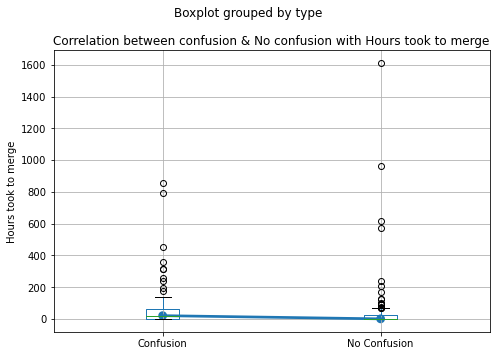

In [40]:
ax = merge_time_df.boxplot(column='Merge_time_Hrs', by='type', showfliers=True, 
                positions=range(merge_time_df.type.unique().shape[0]), figsize =(7, 5))

sns.pointplot(x='type', y='Merge_time_Hrs', data=merge_time_df.groupby('type', as_index=False).median(), ax=ax)
plt.ylabel('Hours took to merge')
plt.xlabel('')
ax.yaxis.grid(True) # Hide the horizontal gridlines
ax.xaxis.grid(True) # Show the vertical gridlines
plt.title('Correlation between confusion & No confusion with Hours took to merge')
plt.show()

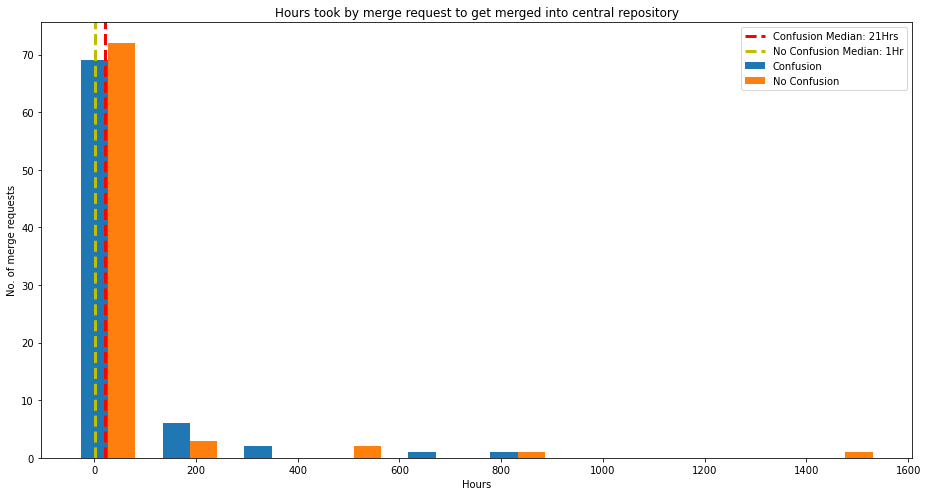

In [77]:
fig, ax = plt.subplots()
b_heights, b_bins = np.histogram(pd.to_numeric(data2DF['Merge_time_Hrs']))
a_heights, a_bins = np.histogram(pd.to_numeric(data1DF['Merge_time_Hrs']), bins=b_bins)
width = (a_bins[1] - a_bins[0])/3
ax.bar(a_bins[:-1], a_heights, width=width, facecolor='tab:blue') #confusion
ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='tab:orange') #no-confusion
plt.axvline(pd.to_numeric(data1DF['Merge_time_Hrs']).median(), color='r', linestyle='dashed', linewidth=3)
plt.axvline(pd.to_numeric(data2DF['Merge_time_Hrs']).median(), color='y', linestyle='dashed', linewidth=3)
plt.title('Hours took by merge request to get merged into central repository')
plt.xlabel("Hours")
plt.ylabel("No. of merge requests")
confusion_mean = np.round(np.median(data1DF['Merge_time_Hrs']), 3)
sample_mean = np.round(np.median(data2DF['Merge_time_Hrs']), 3)
ax.legend(['Confusion Median: '+str(int(confusion_mean))+'Hrs', 'No Confusion Median: '+str(int(sample_mean))+'Hr', 'Confusion', 'No Confusion'])
plt.show()

In [ ]:
#AVERAGE COMMITS IN BOTH GROUP
import gitlab

with open('Credentials.json') as f:
    data = json.load(f)
    mariadb_pwd = data['MariaDB_PWD']
    git_token = data['GIT_Token']

gl = gitlab.Gitlab(url='https://git.cgm.ag', private_token=git_token)
project = gl.projects.get(3982)

manual_label_df = pd.read_excel('final_data/Merge__request_with_confusion_smells_data.xlsx')

for index, row in manual_label_df.iterrows():
    manual_label_df.loc[index,'noOfCommits'] = len(project.mergerequests.get(row['MRIID']).commits(order_by="updated_at", get_all=True))

sample_df = pd.read_excel('final_data/Merge_request_sample_no_confusion_smells_data.xlsx')

for index, row in sample_df.iterrows():
    sample_df.loc[index,'noOfCommits'] = len(project.mergerequests.get(row['MRIID']).commits(order_by="updated_at", get_all=True))
    
manual_label_df.to_excel('final_data/Merge__request_with_confusion_smells_data.xlsx')
sample_df.to_excel('final_data/Merge_request_sample_no_confusion_smells_data.xlsx')

In [19]:
manual_label_df = pd.read_excel('final_data/Merge__request_with_confusion_smells_data.xlsx')
sample_df = pd.read_excel('final_data/Merge_request_sample_no_confusion_smells_data.xlsx')
np.average(manual_label_df['noOfCommits']), np.average(sample_df['noOfCommits'])

(8.113924050632912, 5.253164556962025)